# 01 - Exploração e Limpeza de Dados
Este notebook realiza a **análise exploratória dos dados (EDA)** e o **pré-processamento inicial** do dataset *Fetal Health Classification*.
As etapas incluem:

1. Carregamento e inspeção do dataset bruto  
    - Remoção de colunas não utilizáveis  
    - Separação entre variáveis preditoras e alvo  
2. Análise exploratória (EDA)
   - Verificação de tipos, estatísticas, duplicatas e ausentes
   - Histogramas
   - Boxplots
   - Correlação
   - Investigação de outliers
3. Normalização e salvamento do dataset
   - Salvamento do scaler com `StandardScaler`
   - Salvamento do dataset processado

In [16]:
# Imports das funções utilitárias
from src.preprocessing import (load_raw_dataset, remove_columns, split_features_target, plot_histograms, plot_target_distribution, 
                               plot_boxplots, plot_correlation_matrix,find_outliers_iqr , fit_and_save_scaler, save_processed_dataset)

## 1. Carregamento e inspeção do dataset bruto

In [4]:
df = load_raw_dataset("../data/raw/fetal_health.csv")
print(f"Linhas: {df.shape[0]}, Colunas: {df.shape[1]}")
df.head()

Linhas: 2126, Colunas: 22


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


### Sobre o Dataset

Este dataset contém 2.126 registros extraídos de exames cardiotocográficos (CTG), utilizados para monitorar a saúde fetal durante a gestação. 
Existem 21 features e uma coluna alvo. As features representam medidas fisiológicas. Entre elas:

- Indicadores derivados do sinal de batimentos cardíacos fetais (FHR) e contrações uterinas:
    `baseline value`, `accelerations`, `fetal_movement`,`uterine_contractions`, etc.

- Indicadores de variabilidade:  
  `abnormal_short_term_variability`, `mean_value_of_short_term_variability`, etc.

- Variáveis estatísticas baseadas no histograma do FHR:
  `histogram_width`, `histogram_min`, `histogram_max`,  
  `histogram_mode` etc.

### Variável Alvo:
- `fetal_health`: 1 (Normal), 2 (Suspeito) e 3 (Patológico)

Mais informações sobre o dataset estão documentadas em [Documentação do dataset](../data/README.md)

Como não existe coluna de ID e todas as features são numéricas e apropriadas para modelagem, nenhuma variável precisa ser removida nesta etapa de pré-processamento.

Mantivemos todas as features durante o pré-processamento. Mesmo que algumas pareçam muito correlacionadas, como: `several_decelerations` e 
`prolongued_decelerations`. Além de outras que serão citadas ao logo deste notebook.
A possível seleção/exclusão de variáveis será analisada, com validação cruzada e métricas apropriadas, apenas nas fases de modelagem. Evitando 
análise unicamente por intuição (heurística).

### Conversão de dados

Há um detalhe importante, percebe-se que o alvo, classes, está como ``float64``. Porém, a mesma é categórica, por isso, será feito o `cast` para `int64`

In [5]:
df['fetal_health'] = df['fetal_health'].astype('int64')

### Separação entre features e alvo

Separar as variáveis preditoras da variável alvo é útil na fase de exploração, pois:

- evita misturar os atributos de entrada com a classe alvo;
- facilita a visualização (histogramas, boxplots, correlação);
- permite identificar outliers e distribuições apenas nas features;
- prepara a base para o pré-processamento e para a modelagem futura.

É uma separação é apenas organizacional.

In [6]:
feature_df, target = split_features_target(df, target='fetal_health')

## 2. Análise exploratória (EDA)

### Ausência de valores ausentes e duplicados

O dataset não possui valores ausentes. Portanto, não será necessário imputação de dados.  
Porém, há dados duplicados, 13 no total. Como é um dataset fisiológico derivado de exames CTG, as duplicatas não têm significado clínico, podemos
 entendê-las como repetições do arquivo original.
Além de poderem enviesar certos modelos, principalmente KNN, Naive Bayes e Redes Neurais, Não há razão para mantê-los.

In [7]:
# Dados faltosos e duplicados
print("\nLinhas duplicadas:", df.duplicated().sum())

print("\nValores ausentes:")
print(feature_df.isnull().sum())


Linhas duplicadas: 13

Valores ausentes:
baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                

In [8]:
# Removendo as duplicatas
df = df.drop_duplicates()

### Tipos de dados

Todas as variáveis do dataset são numéricas compostas de valores contínuos (`float`).  Logo não será necessária codificação categórica.


In [9]:
print("Tipos de dados:")
print(feature_df.dtypes)

Tipos de dados:
baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks                                 fl

### Análise das Distribuições (Histogramas)

Com a predominância dos dados numéricos, serão utilizados histogramas, já que permitem visualizar a distribuição das mesmas da melhor forma.  
Vemos que as variáveis apresentam comportamentos estatísticos bastante distintos: 
Algumas features possuem distribuição altamente concentrada em torno de um único valor, como ``fetal_movement`` e ``severe_decelerations``, onde a
 maioria dos registros está próxima de zero.
Já outras, como as variáveis de histogramas são mais dispersas, ainda que possuam assimetria para a esquerda ou direita. 
Mais detalhes da análise dos histogramas pode ser encontradas no [artigo.](../reports/artigo.pdf) 

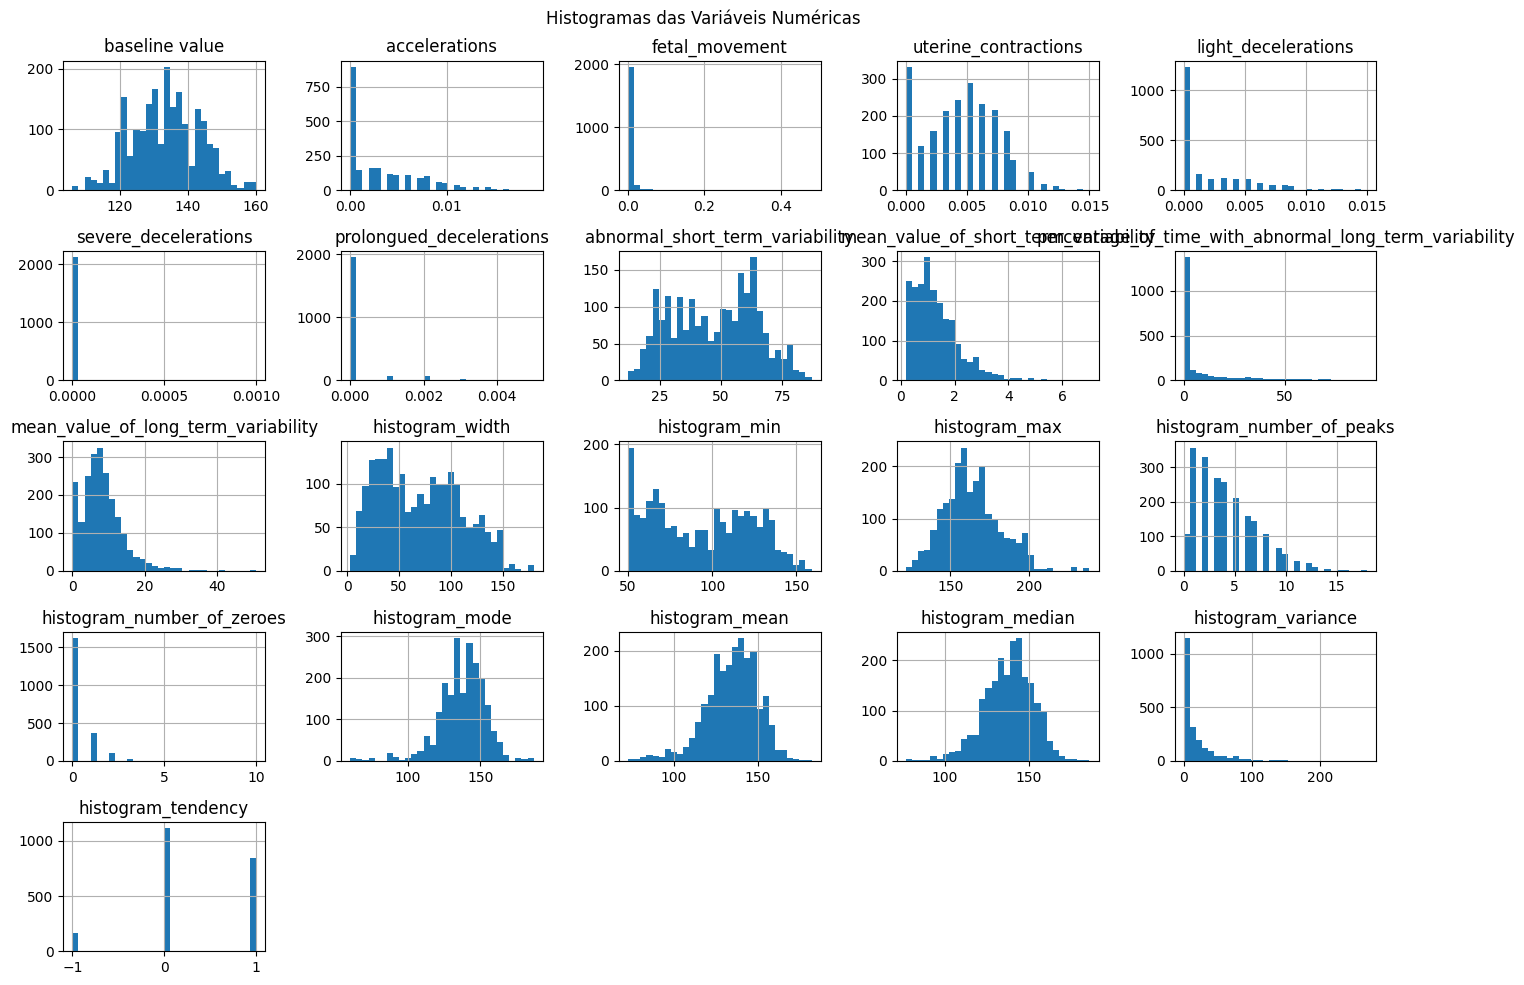

In [10]:
plot_histograms(feature_df)

### Boxplots e análise de outliers

Os boxplots são uma ótima ferramenta de analisar, visualmente, a presença de outiliers. Aqui revelam a presença de outliers principalmente nas
 variáveis que apresentam distribuição concentrada em torno de um único valor (exemplo: `fetal_movement`, `pronlogued_decelerations`).  
Esses valores extremos são esperados e representam eventos reais, como picos de casos ou hospitalizações.  
Por isso, optou-se por manter os outliers no dataset.


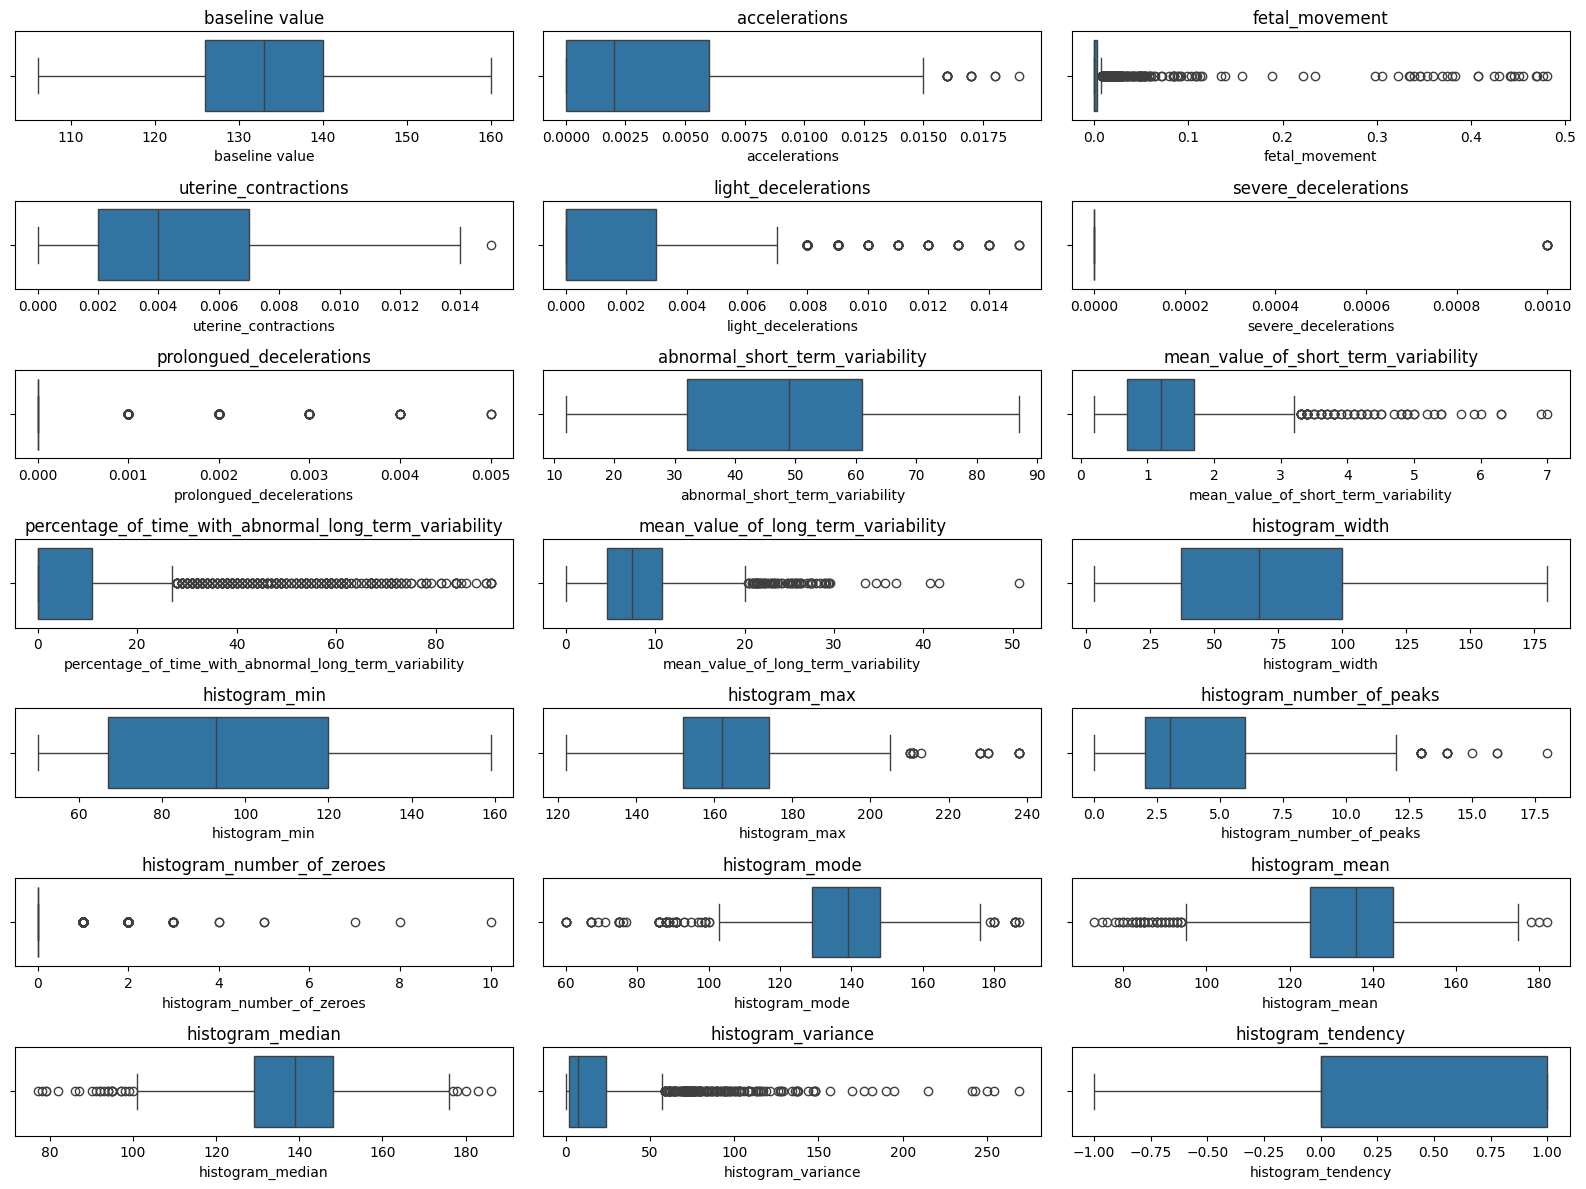

In [11]:
plot_boxplots(feature_df)

### Análise de Outliers (IQR)

Foi aplicado a técnica do Intervalo Interquartil (IQR) para identificar valores extremos nas variáveis numéricas.  
Observa-se que várias features apresentam um grande número de outliers, especialmente nas variáveis cujo valor típico é muito próximo de zero.
Mas isso não é um ruído do dataset, muito pelo contrário, alores isolados representam eventos clínicos raros, como:

- movimentos fetais mais intensos,
- desacelerações severas,
- ou alterações abruptas no padrão de variabilidade cardíaca.

Por isso, decidiu-se manter esses outliers, pois eles carregam informação importante e refletem fenômenos reais, sendo essenciais para uma modelagem
 fiel e para o desempenho dos modelos.
 
Vemos a quantidade de outiliers por coluna a seguir, as colunas que não aparecem não os possuem, sendo elas: `baseline value`, 
`abnormal_short_term_variability`, `histogram_width`, `histogram_min` e `histogram_tendency`. 


In [12]:
# Quntidade de outiliers por feature

for col in df.columns:
    outliers, lower, upper = find_outliers_iqr(df[col])
    if outliers.count() == 0:
        continue
    print(f"{col}: {outliers.count()} outliers")


accelerations: 14 outliers
fetal_movement: 305 outliers
uterine_contractions: 1 outliers
light_decelerations: 150 outliers
severe_decelerations: 7 outliers
prolongued_decelerations: 178 outliers
mean_value_of_short_term_variability: 70 outliers
percentage_of_time_with_abnormal_long_term_variability: 305 outliers
mean_value_of_long_term_variability: 71 outliers
histogram_max: 24 outliers
histogram_number_of_peaks: 19 outliers
histogram_number_of_zeroes: 502 outliers
histogram_mode: 73 outliers
histogram_mean: 45 outliers
histogram_median: 28 outliers
histogram_variance: 184 outliers
fetal_health: 467 outliers


### Distribuição da variável alvo

Para a variável alvo `fetal_health`, utilizamos um gráfico de barras (countplot), pois ela é categórica.  
Observa-se um forte desbalanceamento, com predominância da classe 1 (“Normal”).  
Esse desbalanceamento é comum em dados clínicos e será considerado na fase de modelagem.

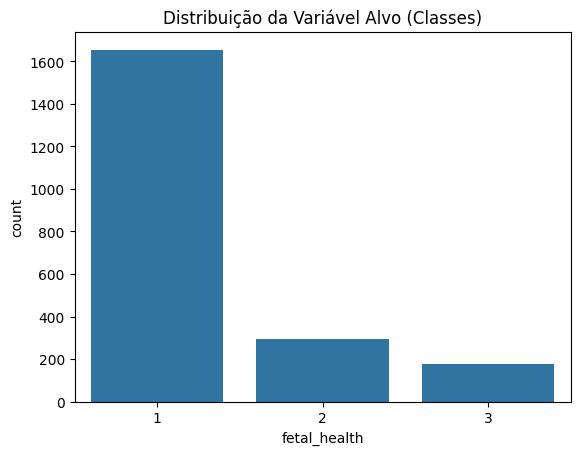

In [13]:
plot_target_distribution(target)

### Matriz de Correlação

A matriz de correlação apresenta um padrão complexo.  
Embora exista a diagonal principal (correlação perfeita da variável consigo mesma), a maior parte das correlações entre features permanece **baixa**, variando entre aproximadamente **−0.25 e +0.25**, indicando dependência linear fraca ou inexistente.

Entretanto, observamos alguns grupos bem definidos de correlações mais fortes, especialmente entre as variáveis derivadas do histograma:

- **histogram_mean**, **histogram_median** e **histogram_mode** apresentam correlação quase perfeita entre si (≈ 1), refletindo que todas medem 
características semelhantes da distribuição dos batimentos cardíacos fetais.
- Outras variáveis do histograma, como **histogram_min**, **histogram_max** e **histogram_number_of_peaks**, também exibem correlações moderadas a altas (acima de 0.75, ou abaixo de -0.75), o que é esperado, pois essas medidas são estatisticamente relacionadas.

Fora desse conjunto, o restante das features apresenta correlação fraca, indicando que muitas variáveis carregam informação distinta e não redundante.

Esse comportamento tem duas implicações importantes:

1. **Alguns grupos de variáveis são redundantes** (especialmente as baseadas em histogramas), podendo influenciar modelos sensíveis à multicolinearidade como a Regressão Logística e Redes Neurais.
2. **As demais variáveis são amplamente independentes**, o que favorece algoritmos que assumem independência entre features, como o Naive Bayes, que 
presume a idepêndencia das features.

A presença de um pequeno grupo de variáveis altamente correlacionadas não compromete a modelagem, mas poderá impactar alguns algoritmos durante a 
avaliação, como foi citado, especialmente nos coeficientes de modelos lineares. Esse ponto será retomado no Notebook de modelagem.

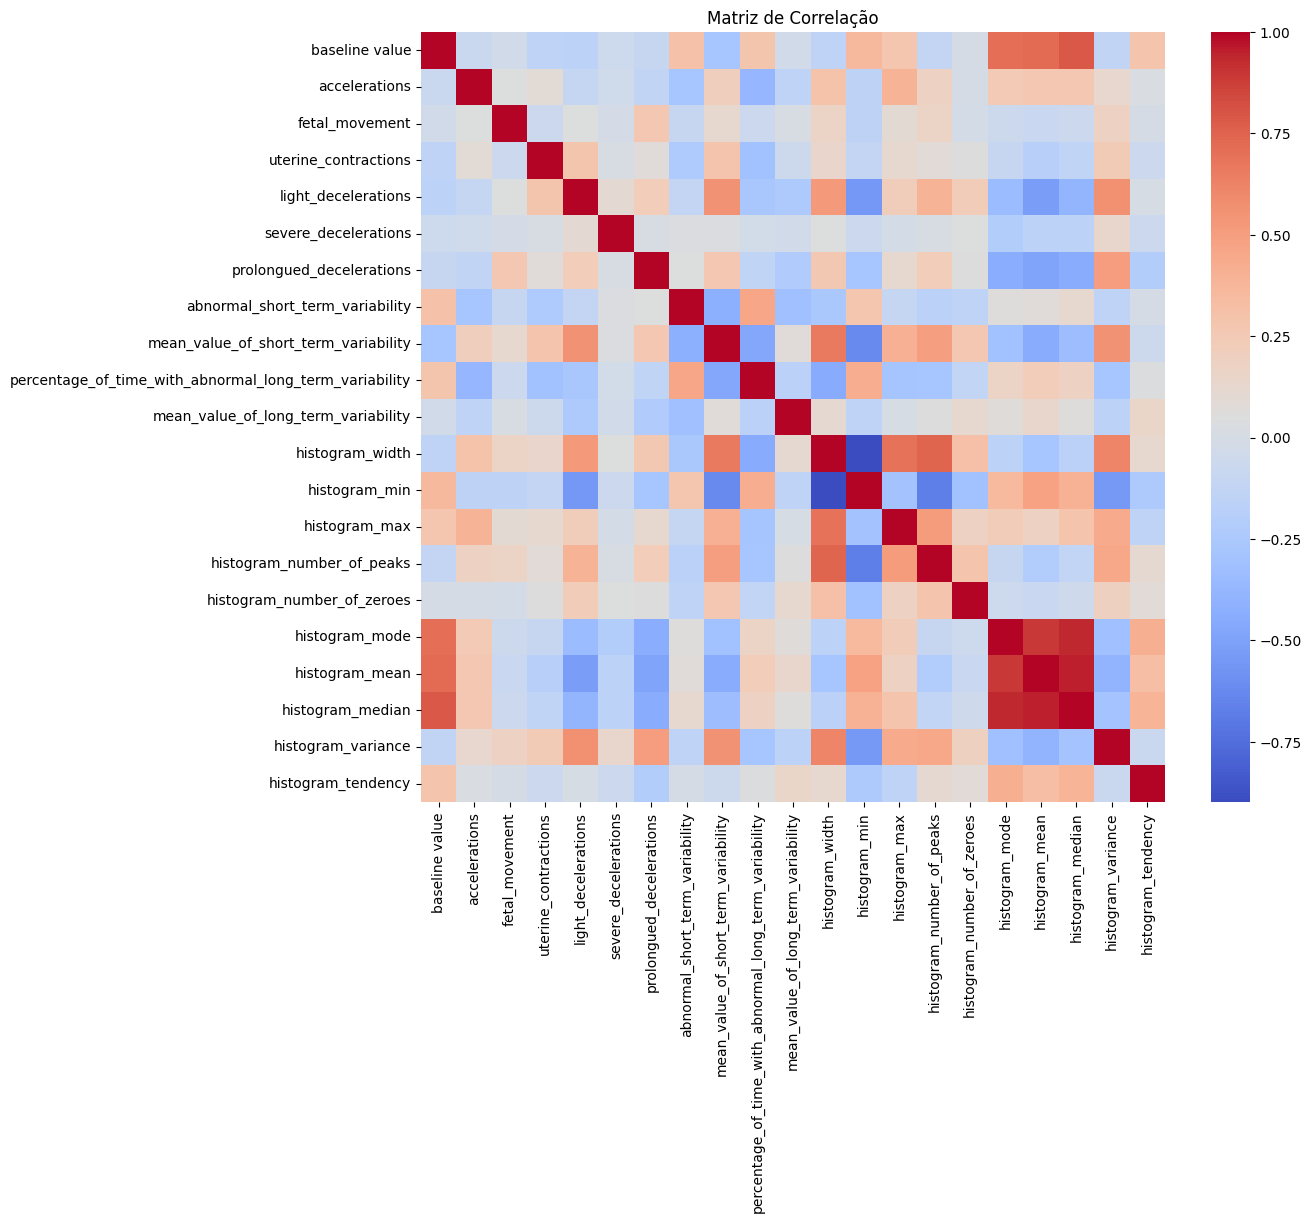

In [14]:
plot_correlation_matrix(feature_df)

## 3. Normalização e salvamento do dataset

### Normalização dos Dados

A normalização é uma etapa importante quando utilizamos modelos que dependem de distâncias ou assumem variáveis escaladas de forma semelhante.
Optou-se por utilizar o **StandardScaler**, que transforma cada feature para média 0 e desvio padrão 1.

Essa escolha é adequada para modelos que serão utilizados, como:

- KNN (baseado em distância)
- Regressão Logística (otimização mais estável)
- MLP (rede neural converge mais rápido)
- Naive Bayes Gaussiano (assume que seja uma distribuição normal)

A normalização é ajustada apenas nos **dados de treino**, dentro do procedimento de validação cruzada, para evitar **data leakage**.
Aqui ajustamos (`fit`) o scaler apenas para salvá-lo e disponibilizá-lo para a etapa de modelagem, para um posssível teste de baseline. Além de salvar os transformers, uma boa prática em ML/AI.

Outras normalizações existem como o ``Min-Max``, scaling que transforma os valores para o intervalo [0, 1].  
Apesar de ser útil em alguns casos, ele é muito sensível a outliers — e este dataset possui outliers nas variáveis de contagem (casos e hospitalizações).

O StandardScaler é mais robusto para esse cenário, pois, não "colapsa" valores por causa de outliers e dá uma escala bem distribuída para variáveis que podem assumir valores amplos.

Por isso, o StandardScaler foi escolhido.

## Salvando o dataset processado

Após normalização e ajustes, salvamos:

- o dataset processado (`fetal_health_processed.csv`)
- o scaler treinado (`preprocessor.joblib`)

Esses arquivos serão usados pelos notebooks de [modelagem](02_modeling.ipynb) e [avaliação](03_evaluating.ipynb).


In [15]:
import os
# Caminhos
processed_dir = "../data/processed"
scaler_path = os.path.join(processed_dir, "preprocessor.joblib")
processed_csv_path = os.path.join(processed_dir, "fetal_health_processed.csv")

# Salvando os dados
# scaler = fit_and_save_scaler(feature_df, save_path=scaler_path)
# save_processed_dataset(df, processed_csv_path)